In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt
import json

# Importing packages
import feedstock as fs
import pp
import gasifier as g
import fuel as fu
import energy as en
import outputs as op

For species Fe(c), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 4.2881898

For species Fe(c), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 3.425820683333331

For species Fe(c), discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 8.486560101557188

For species Cr(cr), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  749.1520512400002
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  113.24055562733336
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in s/R detec

In [2]:
# Grabbing data from JSON file
with open('data/data.json','r') as dataFile:
    data = json.load(dataFile)
    dataFile.close()

In [3]:
# Table2 = data['Thamavithya2010']['Table2']
# df = pd.DataFrame(Table2)
# df.head()

In [4]:
# fuelID = "ThamaSawdust"
# species=['CO','H2','CH4','CO2','N2']
# moist = fu.moisture(fuelID)
# n = len(Table2)
# ER = np.array([run['ER'] for run in Table2])
# T = np.array([run['Tgas'] for run in Table2]) + 273.15 # K
# experimental = np.zeros((n, len(species)))
# for i in range(n):
#     for j, sp in enumerate(species):
#         experimental[i,j] = Table2[i][sp]/100
# CC = np.array([run['CarbonConv'] for run in Table2])

In [5]:
# predicted = np.zeros_like(experimental)
# for i in range(n):
#     report0 = g.gasifier(fuelID, moist=moist, T=T[i], air=ER[i], airType='ER', species=species)
#     CC_pred = report0['CC']
#     C_avail0 = CC[i]/CC_pred
#     DT, sqerr = g.findTquasi(fuelID, experimental[i], moist=moist, T0=T[i], air=ER[i], airType='ER', C_avail=1.0, species=species)
#     report1 = g.gasifier(fuelID, moist=moist, T=T[i]-DT, air=ER[i], airType='ER', species=species+['C(gr)'], C_avail=1.0)
#     for j, sp in enumerate(species):
#         predicted[i,j] = report1[sp]
#     print(i)
# print(predicted)

In [6]:
# plt.scatter(ER, experimental[:,4], label='CO')
# plt.plot(ER, predicted[:,4], label='CO pred')
# plt.grid()
# plt.show()

In [7]:
# This uses data from 10.1007/s11708-020-0710-3 (Guo et al., 2020)

# Fuel is already in database (Compressed Corn Straw)
fuelID = 'GuoCorn'

GuoDict = data["Guo2021"]["Table3"]

# Experimental data information
T = np.array([700, 800, 900]) # °C
T = T + 273.15 # K
ER = 0.21 # constant
moist = 0
species = ['CO2', 'CO', 'CH4', 'H2']
experimental = np.array([[17.1, 14.7, 6.36, 7.58],
                         [16.5, 16.4, 6.07, 7.97],
                         [15.7, 17.8, 5.60, 8.35]]) # %
experimental = experimental/100 # fraction

In [8]:
# Creating a range of values for smooth, continuos model response
Tl = np.linspace(T[0], T[-1], 100) # K
CO2l = np.zeros_like(Tl)
COl = np.zeros_like(Tl)
CH4l = np.zeros_like(Tl)
H2l = np.zeros_like(Tl)

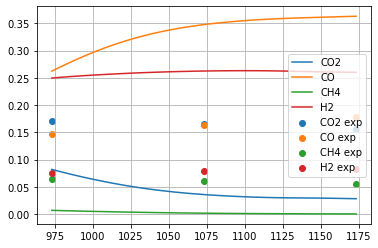

In [9]:
# First test: raw model, no modifications

for i, t in enumerate(Tl):
    report = g.gasifier2(fuelID, T=t, air=ER, species=species)[0]
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.legend()
plt.grid()
plt.savefig("results.png")
plt.show()

162.26182796577393 0.018583116160797067
219.20230736032113 0.020473357213055786
298.3845680031221 0.021098602694569275
226.6162344430724


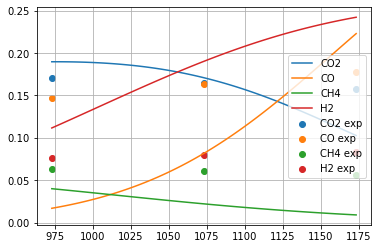

In [10]:
# Second test: modified model finds DT but not C_avail, uses average DT value

predicted = np.zeros_like(experimental)
DTsum = 0
for i, t in enumerate(T):
    Tquasi, sqerr = g.findTquasi(fuelID, experimental[i], T0=t, air=ER, species=species, C_avail=1.0)
    report = g.gasifier2(fuelID, T=Tquasi, air=ER, species=species, C_avail=1.0)[0]
    for j, sp in enumerate(species):
        predicted[i,j] = report[sp]
    DT = t - Tquasi
    DTsum += DT
    print(DT, sqerr)

DTav = DTsum/len(T)
print(DTav)

for i, t in enumerate(Tl):
    report = g.gasifier2(fuelID, T=t-DTav, air=ER, species=species)[0]
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.grid()
plt.legend()
plt.savefig("results2.png")
plt.show()

In [11]:
# # Third test: modified model finds DT and C_avail, uses average values

# predicted = np.zeros_like(experimental)
# sums = [0, 0]
# for i, t in enumerate(T):
#     X = g.findParams(fuelID, experimental[i], T0=t, air=ER, species=species)
#     DT, C_avail, sqerr = X
#     report = g.gasifier(fuelID, T=t-DT, air=ER, species=species, C_avail=C_avail)
#     for j, sp in enumerate(species):
#         predicted[i,j] = report[sp]
#     sums[0] += DT
#     sums[1] += C_avail
#     print(DT, C_avail, sqerr)
# DTav = sums[0]/len(T)
# C_avail_av = sums[1]/len(T)
# print(DTav, C_avail_av)

# for i, t in enumerate(Tl):
#     report = g.gasifier(fuelID, T=t-DTav, air=ER, species=species, C_avail=C_avail_av)
#     CO2l[i] = report['CO2']
#     COl[i] = report['CO']
#     CH4l[i] = report['CH4']
#     H2l[i] = report['H2']

# plt.plot(Tl, CO2l, label='CO2')
# plt.plot(Tl, COl, label='CO')
# plt.plot(Tl, CH4l, label='CH4') 
# plt.plot(Tl, H2l, label='H2')
# plt.scatter(T, experimental[:,0], label='CO2 exp')
# plt.scatter(T, experimental[:,1], label='CO exp')
# plt.scatter(T, experimental[:,2], label='CH4 exp')
# plt.scatter(T, experimental[:,3], label='H2 exp')
# plt.grid()
# plt.legend()
# plt.savefig("results3.png")
# plt.show()

In [12]:
GuoDF = pd.DataFrame.from_dict(GuoDict)

n = len(GuoDict)
T = np.zeros(n)
ER = np.zeros(n)
SB = np.zeros(n)
DMP = np.zeros(n)
species = ['CO2', 'CO', 'CH4', 'H2']
experimental = np.zeros((n, len(species)))
for i, run in enumerate(GuoDict):
    T[i] = run['T']+273.15
    ER[i] = run['ER']
    SB[i] = run['S/B']
    DMP[i] = run['DMP']
    for j, sp in enumerate(species):
        experimental[i,j] = run[sp]/100
GuoDF.head()

,Run,T,ER,S/B,DMP,CO2,CO,CH4,H2,Tar
0,1,700,0.21,0.0,0,17.1,14.7,6.36,7.58,6.20
1,2,740,0.26,0.0,0,17.8,15.5,7.24,7.93,5.56
2,3,770,0.31,0.0,0,18.8,16.4,7.89,8.91,4.69
3,4,820,0.34,0.0,0,20.2,15.2,6.41,8.07,3.97
4,5,700,0.21,0.2,0,17.8,12.9,4.21,9.51,5.34


In [13]:
predicted = np.zeros_like(experimental)
for i, run in enumerate(GuoDict):
    report0 = g.gasifier2(fuelID, T=T[i], air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)[0]
    sqErr = 0
    for j, sp in enumerate(species):
        predicted[i,j] = report0[sp]
        sqErr += (predicted[i,j]*100 - experimental[i,j]*100)**2
    RMSE = np.sqrt(sqErr/len(species)) # as a percentage
    print(i, RMSE)

0 11.694500676553327
1 12.089277279053348
2 10.456973758211397
3 10.191720047176723
4 11.851285196752736
5 9.979375070579605
6 9.062206970762466
7 11.093901730400665
8 10.221214458891376
9 9.84769376454269
10 14.787174416319171
11 14.602087644717438


In [14]:
predicted = np.zeros_like(experimental)
DTav = 0
for i, run in enumerate(GuoDict):
    Tquasi, sqerr = g.findTquasi(fuelID, experimental[i], T0=T[i], air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)
    report1 = g.gasifier2(fuelID, T=Tquasi, air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)[0]
    sqErr = 0
    for j, sp in enumerate(species):
        predicted[i,j] = report1[sp]
        sqErr += (predicted[i,j]*100 - experimental[i,j]*100)**2
    RMSE = np.sqrt(sqErr/len(species)) # as a percentage
    DTav += T[i] - Tquasi
    print(i, Tquasi - T[i], RMSE)
DTav /= len(T)
print(DTav)

0 -162.26182796577393 6.815995187937904
1 -157.60991070477905 6.498524379754103
2 -169.91611501409238 6.126204937041203
3 -231.7145866260587 5.746844500183266
4 -212.52466217233382 5.907993489776155
5 -182.1716360037974 4.993011224137987
6 -185.0140910643953 4.5069262249690905
7 -128.0184736976571 6.744418062677388
8 -103.80679731541545 6.487612270417712
9 -97.26467380599036 6.214314774467556
10 -219.20230736032113 7.154256986762446
11 -298.3845680031221 7.262679033003123
178.99080414447806


In [15]:
predicted = np.zeros_like(experimental)
for i, run in enumerate(GuoDict):
    report0 = g.gasifier2(fuelID, T=T[i]-DTav, air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)[0]
    sqErr = 0
    for j, sp in enumerate(species):
        predicted[i,j] = report0[sp]
        sqErr += (predicted[i,j]*100 - experimental[i,j]*100)**2
    RMSE = np.sqrt(sqErr/len(species)) # as a percentage
    print(i, RMSE)

0 6.825538972576542
1 6.575959338909809
2 6.152284886998412
3 6.759392032242108
4 6.018598570867953
5 4.995205592440259
6 4.519388268912508
7 6.953136543609221
8 7.292363024720137
9 7.383008654664308
10 7.5293675713631885
11 11.415554944867926
